In [ ]:
# CRNN + GRU
# CRNN : CNN 과 RNN을 혼합해서 만든 모델
# CTC : 가능한 모든 경로의 확률의 합을 결과의 확률로 정의
# 캡차에 이용되는 문자열을 이미지의 형태로 갖고 있는 데이터셋


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/captcha/captcha-version-2-images.zip' -d '/content/drive/MyDrive/Colab Notebooks/captcha/data'

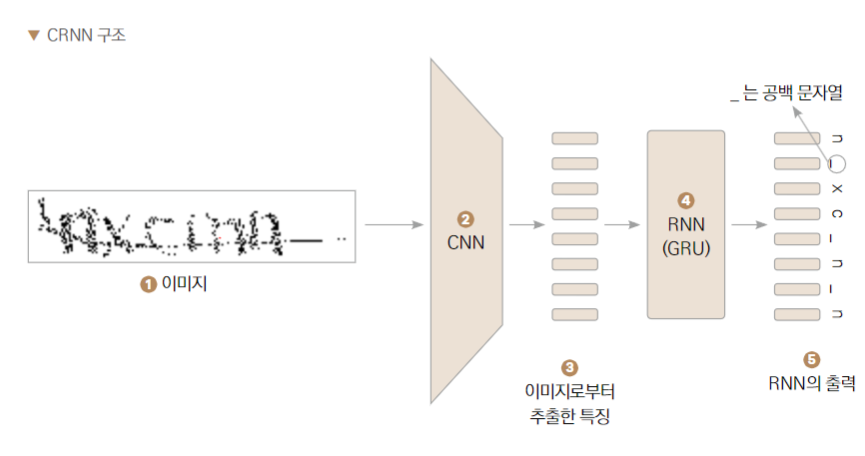

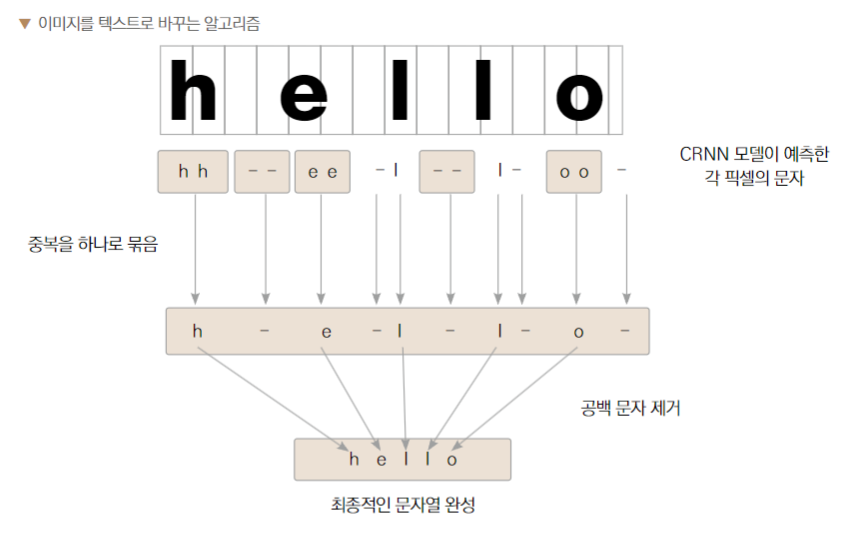

In [2]:
# 이미지로 부터 텍스트 정보를 추출할때 사용
# 음원의 주파수 정보를 해설

In [3]:
# 데이터 확인
import glob
import matplotlib.pyplot as plt
from PIL import Image

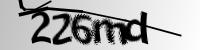

In [17]:
imagelist = glob.glob('/content/drive/MyDrive/Colab Notebooks/captcha/data/samples/samples/*.png')
Image.open(imagelist[0])

In [20]:
Image.open(imagelist[0]).size

(200, 50)

In [18]:
# png RGB 채널 , 투명도를 나타는 알파채널
imagelist[0]

'/content/drive/MyDrive/Colab Notebooks/captcha/data/samples/samples/226md.png'

In [21]:
# 학습용 데이터 셋 만들기  
# 정답 : 파일명
# 정답에 등장하는 모든 문자를로 BOW를 만들어 줌
import numpy as np
from torch.utils.data.dataset import Dataset


In [22]:
def get_Bow(corpus):
  # 공백문자 <pad>를 0으로 셋팅
  BOW = {"<pad>":0}

  for w in corpus:
    if w not in BOW.keys():
      BOW[w] = len(BOW.keys())
  return BOW

In [28]:
import string
class Captcha(Dataset):
  def __init__(self,train=True):
    # 소문자, 숫자만 정답
    self.corpus = string.ascii_lowercase + string.digits
    self.BOW = get_Bow(self.corpus)
    self.imgfiles = glob.glob('/content/drive/MyDrive/Colab Notebooks/captcha/data/samples/samples/*.png')
    self.train = train
    split_number = int(len(self.imgfiles)*0.8)
    self.trainset = self.imgfiles[:split_number]
    self.testset = self.imgfiles[split_number:]
  # 캡차를 숫자로 표현  - BOW  
  def get_seq(self,line):
    label = []
    for w in line:
      label.append(self.BOW[w])
    return label
  def __len__(self):
    if self.train:
      return len(self.trainset)
    else:
      return len(self.testset)
  def getitem(self,dataset,index):
    # png 파일을 RGB 파일로 변환
      data = Image.open(dataset[index]).convert("RGB")
      label = dataset[index].split("/")[-1]
      # 확장자 제거
      label = label.split(".png")[0]
      data = np.array(data).astype(np.float32)
      # 파이토치: 채널이 앞에
      data = np.transpose(data,(2,0,1))
      label = np.array(label)
      return data,label
  def __getitem__(self, index):
    if self.train:
      return self.getitem(self.trainset,index)
    else:
      return self.getitem(self.testset,index)

In [29]:
# CRNN 모델
# CNN 모델은 ResNet 을 이용
# imagenet 계열은 픽셀이 정사각형 ,  직사각형  가로픽셀이 세로보다 많은 구조  그래서 커널은 가로를 길게
# CNN의 최종 출력은 RNN의 입력으로 들어가는데. 세로방향 픽셀 한개만 존재
# conv 를 통과할때만다. 세로방향을 픽셀을 줄여나간다  3 x 5
# 입력 - [C(3x5) - BN -Relu] - [C(3x5) - BN -Relu] -   결합  - 출력
#      ---------------------------------------------

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [33]:
class BasicBlock(nn.Module):
  def __init__(self,in_channels, out_channels, kernel_size=(3,5), strid=(2,1)):
    super(BasicBlock,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                           kernel_size=kernel_size, stride=strid
                           )
    self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels,
                           kernel_size=(3,3), stride=1
                           )
    self.downsample = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                           kernel_size=kernel_size, stride=strid
                           )
    self.bn1 = nn.BatchNorm2d(num_features=out_channels)
    self.bn2 = nn.BatchNorm2d(num_features=out_channels)

    self.relu = nn.ReLU()
  def forward(self, x):
    x_copy = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x_copy = self.downsample(x_copy)
    x += x_copy  # 입력데이터와 결과를 합친다
    x = self.relu(x)
    return x

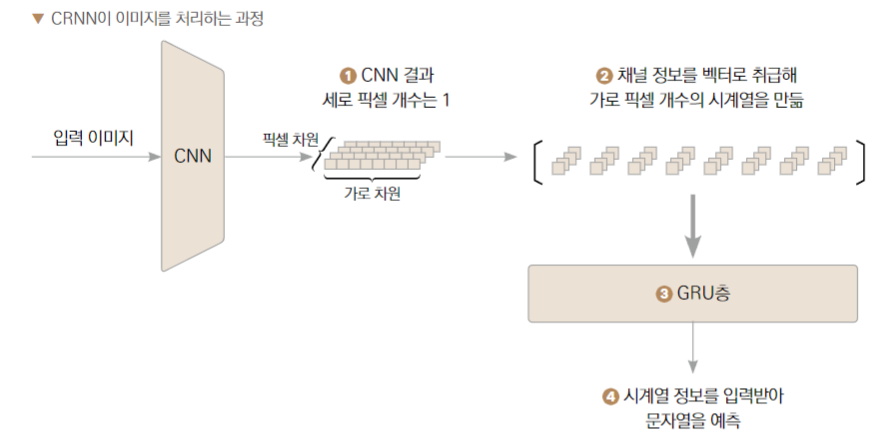

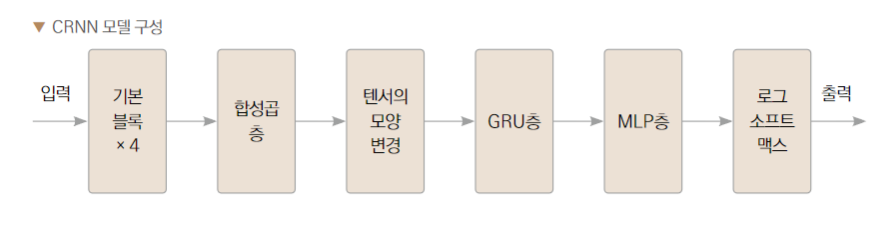

In [34]:
class CRNN(nn.Module):
  def __init__(self, output_size):
    super(CRNN,self).__init__()
    # CNN
    self.c1 = BasicBlock(3,64)
    self.c2 = BasicBlock(64,64)
    self.c3 = BasicBlock(64,64)
    self.c4 = BasicBlock(64,64)
    self.c4 = nn.Conv2d(64,64,kernel_size=(2,5))

    self.gru = nn.GRU(64,64,batch_first=False)

    self.fc1 = nn.Linear(64,128)
    self.fc2 = nn.Linear(128,output_size)
    self.relu = nn.ReLU()
  def forward(self,x):
    # (B, 3,50,200)
    x = self.c1(x)
    x = self.c2(x)
    x = self.c3(x)
    x = self.c4(x)
    x = self.c5(x)
    # (B, 64 ,1, 180)

    #(B,64,180)
    x = x.view(x.shape[0],64,-1)
    #(180,B,64)
    x = x.permute(2,0,1)

    x, _ =  self.gru(x)

    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    x = F.log_softmax(x,dim=1)
    return x

In [35]:
import tqdm
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = Captcha()
loader = DataLoader(dataset,batch_size=8)

model = CRNN(output_size=len(dataset.BOW)).to(device)

optim = Adam(model.parameters(), lr=1e-4)

In [36]:
for epoch in range(1):
  iterator = tqdm.tqdm(loader)
  for data,label in iterator:
    optim.zero_grad()
    preds = model(data.to(device))
    # CTC 손실계산은 텐서모양까지 적용
    preds_size = torch.IntTensor([preds.size(0)]*8).to(device)
    target_len = torch.IntTensor([ len(txt) for txt in label ]   ).to(device)
    loss = nn.CTCLoss(blank=0)(
        preds, label.to(device), preds_size,target_len
    )
    loss.backward()
    optim.step()
    iterator.set_description(f"epoch:{epoch} loss:{loss.item()}")
torch.save(model.state_dict(), 'CRNN.pth')
                                                       

  0%|          | 0/104 [00:00<?, ?it/s]


TypeError: ignored